# Mammography classification
1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Prepare the data](#Prepare-the-data)
3. [Training the model](#Training-the-model)
  1. [Training parameters](#Training-parameters)
  2. [Start the training](#Start-the-training)
4. [Inference](#Inference)

## Introduction

Welcome to our Mammography Classification based on AWS Sage Maker Image Classification built-in algorithm. In this demo, we will use the Amazon SageMaker image classification algorithm to train on real patients' mammography.

They will be classified in 5 categories:
- Mediolateral-Oblique Left (MLO Left)
- Mediolateral-Oblique Right (MLO Right)
- Cranial-Caudal Left (CC Left)
- Cranial-Caudal Right (CC Right)
- Not a mammography

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [ ]:
%%time
import sagemaker
import boto3

from sagemaker import get_execution_role

role = get_execution_role()
print(role)

sess = sagemaker.Session()
bucket='mammography-workshop'
prefix = 'raw'


In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

## Training the model

Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. For SageMaker Image Classification built-in algorithm, it is mandatory to use GPU instances for the training. For more information on Recommended instances for Image Classification algorithm: https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html#IC-instances
* **Output bucket**: This the s3 bucket in which the training output will be stored. Replace the content in <<>> by the name of the bucket created by CloudFormation. It should look something like this 'output-bucket-mammography-workshop-123456789012'


In [ ]:
bucket_output='<<replace with the bucket created by Cloudformation>>'
prefix_output='<<leave empty or create an output folder and paste it''s name here>>'

s3_output_location = 's3://{}/{}'.format(bucket_output, prefix_output)

ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the new dataset. As mentioned in the beggining, we have 5 different output classes: MLO Right, MLO Left, CC Right, CC Left, Not a mammography.
* **num_training_samples**: This is the total number of training samples. It is set to 875, since it is the amount of available images we have for training. The higher the training samples you have, better are the chances of you getting a good classification model.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run. This is the amount of images that will be loaded into memory for training. If this number is too high, your instance might run out of memory. If this number is too low, your accuracy might suffer.
* **epochs**: Number of training epochs, i.e, the amount of training cycles in a full dataset. The correct number of epochs need to be tested, because you don't want to underfit or overfit your model. Just remember that more epochs means taking longer and costing more. 
* **learning_rate**: Learning rate for training.
* **top_k**: Report the top-k accuracy during training.
* **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode


In [ ]:
ic.set_hyperparameters(num_layers=18,
                       image_shape="3,300,200",
                       num_classes=5,
                       num_training_samples=875,
                       mini_batch_size=50,
                       epochs=20,
                       learning_rate=0.01,
                       optimizer='sgd',
                       top_k=2,
                       precision_dtype='float32'
                      )


## Input data specification
Set the data type and channels used for training the model.

The next block of code defines where the images are and how they are classified.

There are two separate datasets: one for **training** and one for **validation**.

This is important because the model needs to test itself on data that it already knows and with data that it has never seen, in order for us to find out if it is a good model to make generalizations on new data.

In order for us to provide to the model the data already classified, we are using an ".lst" file, that consists of all the location of the images and their classification.



In [ ]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/{}/train/'.format(bucket, prefix)
s3validation = 's3://{}/{}/test/'.format(bucket, prefix)
s3train_lst = 's3://{}/{}/train-data.lst'.format(bucket, prefix)
s3validation_lst = 's3://{}/{}/test-data.lst'.format(bucket, prefix)

train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 'train_lst': train_lst, 'validation_lst': validation_lst }

## Start the training
Start training by calling the fit method in the estimator

In [ ]:
ic.fit(inputs=data_channels, logs=True)


# Data Preparation

You may have noticed that **the best Validation Accuracy found was around 45%, which is not at all good**.

**Training accuracy** so different from your **validation accuracy** is also a bad indicator.

When navigating through the mammography images, you may notice that every image has a different size, and this is the main reason why our Valication Accuracy is so low.

To prove that, we will train the model again, but now we will use **images that were all resized to the same dimension**. In our case: 200 width, 300 height. 

We used OpenCV lib (https://opencv.org/) to perform the resize using Python. For information only, the main code executed can be found below:

    #filepath is the full path for the mammography stored locally
  
    img = cv2.imread(filepath) 

    res = cv2.resize(img,(200,300),interpolation=cv2.INTER_AREA)



**For the sake of time, we already provided you with all the resized images needed for this lab.**

So, let's run it all over again, but now using the resized mammography images for the training stored in the same bucket, but inside **resize** folder




In [ ]:
prefix = 'resize'

# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/{}/train/'.format(bucket, prefix)
s3validation = 's3://{}/{}/test/'.format(bucket, prefix)
s3train_lst = 's3://{}/{}/train-data.lst'.format(bucket, prefix)
s3validation_lst = 's3://{}/{}/test-data.lst'.format(bucket, prefix)

train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 'train_lst': train_lst, 'validation_lst': validation_lst }

# Note that:
# image_shape="num_channels, height, width"

ic.set_hyperparameters(num_layers=18,
                       image_shape="3,300,200",
                       num_classes=5,
                       num_training_samples=875,
                       mini_batch_size=50,
                       epochs=25,
                       optimizer='sgd',
                       learning_rate=0.01,
                       top_k=2,
                       precision_dtype='float32'
                      )

ic.fit(inputs=data_channels, logs=True)



# Training job analytics

We will now plot a pivot table with the analytics collected during training execution.
These are metrics collected from Cloud Watch. So, this graph might not show all checkpoints collected, but the average of those collected in the 1-minute range. Those factors might change the amount of lines ploted in the graph depending on the duration of the execution.




In [ ]:
job_name=ic.latest_training_job.name
metric_name = 'validation:accuracy'
parent = sagemaker.analytics.TrainingJobAnalytics(training_job_name=job_name,metric_names=[metric_name],period=1)
parent.dataframe().sort_values(['value'], ascending=False)


# Inference

***

In order for us to use the model we just trained and tested, we need to deploy it.
To do that, you need to invoke the method *deploy* of the Estimator.
When doing that, AWS will provision a SageMaker EC2 instance (you **won't** be able to see nor manage it through the EC2 console) whose only purpose is to respond to invokations 
We are using an m4.xlarge, but in production, plan accordingly.


In [ ]:
ic_classifier = ic.deploy(initial_instance_count = 1,
                          instance_type = 'ml.m4.xlarge')

## Confusion Matrix explained

Confusion Matrix is one of multiple ways to determine the performance of a classification algorithm.
It basically plots the expected values and the predicted values returned by the model in a matrix layout, so we can easily see how much the model is acing and how much it is failing.

**If my model is ~98% accurate, why would I need a Confusion Matrix?**

Because it still is 2% wrong. And it is important to understand where it is wrong: is it 2% wrong spread all over your classes or do you have a class that is bringing your accuracy down?

Or even the 2% might be misleading. If you have more data on a class that is "easy" to predict and, therefore, it is bringing your accuracy up, but in reality, some other class might have less data but it could be failing to predict correctly. Of course, this is a problem for algorithms classifing 3 or more classes of data, which is our case.

Before we jump into our own model, let's take a look at the example below.
Interpreting the matrix, we discover that there should be 5 cats and 5 dogs in an imaginary image classification training. But when invoking the model, it predicted 4 cats e 6 dogs. **The correct values are in the diagonal part of the matrix, in bold**.



![Confusion Matrix](attachment:images/confusion-matrix.png)

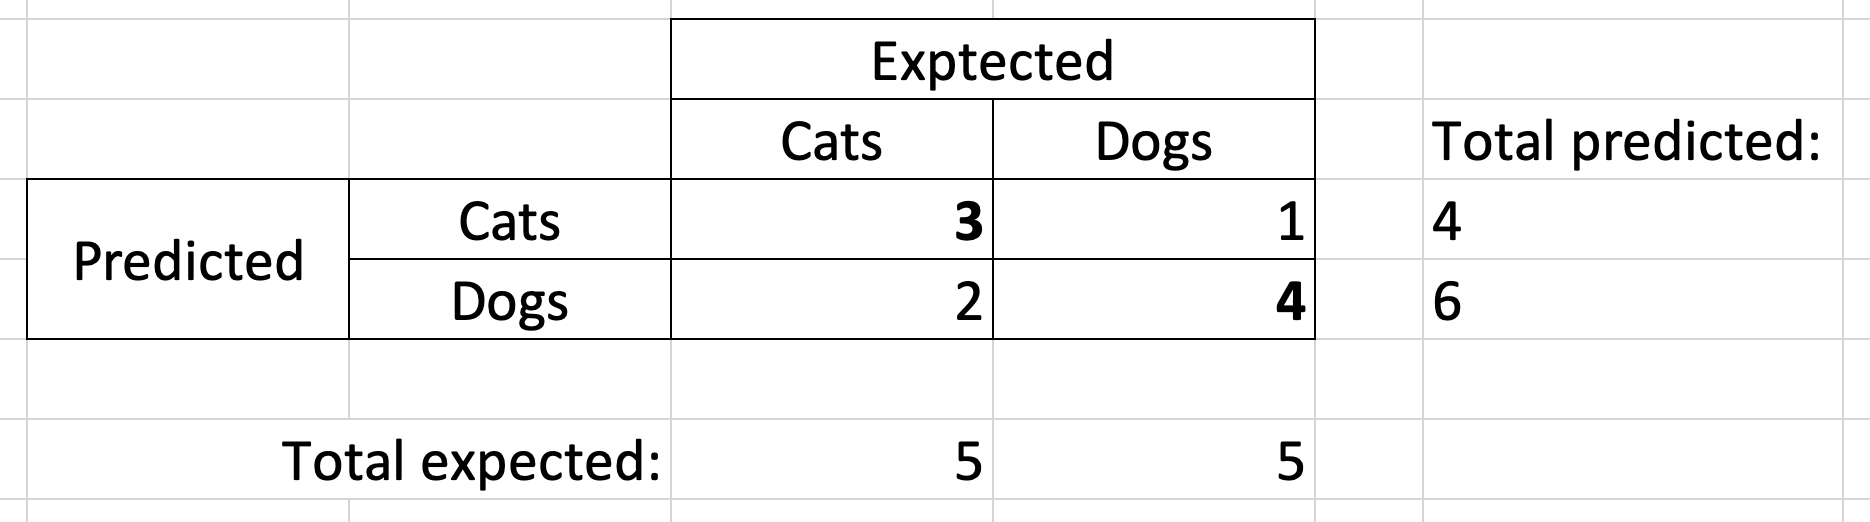



## Confusion Matrix for Mammography Classification

Now that we've understood what is a confusion matrix, let's execute the code below to generate a confusion matrix for our model.

In [ ]:
import sys

import boto3

import logging

import json

from sklearn.metrics import confusion_matrix

import seaborn as sn

import pandas as pd

import numpy as np

from botocore.exceptions import ClientError

debug = False
# debug = True

prefix = "resize/validate"

endpoint_name = ic_classifier.endpoint

expected = []

predicted = []

def list_bucket_objects(bucket_name, prefix):
    """List the objects in an Amazon S3 bucket

    :param bucket_name: string
    :param prefix: string
    :return: List of bucket objects. If error, return None.
    """

    # Retrieve the list of bucket objects
    s_3 = boto3.client('s3')

    try:
        response = s_3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    except ClientError as e:
        # AllAccessDisabled error == bucket not found
        logging.error(e)
        return None

    # Only return the contents if we found some keys
    if response['KeyCount'] > 0:
        return response['Contents']

    return None


def get_object(bucket_name, object_name):
    """Retrieve an object from an Amazon S3 bucket

    :param bucket_name: string
    :param object_name: string
    :return: botocore.response.StreamingBody object. If error, return None.
    """

    # Retrieve the object
    s3 = boto3.client('s3')
    try:
        response = s3.get_object(Bucket=bucket_name, Key=object_name)
    except ClientError as e:
        # AllAccessDisabled error == bucket or object not found
        logging.error(e)
        return None
    # Return an open StreamingBody object
    return response['Body']

def get_expected_value(object_key):
    if "CCD" in object_key:
        return "CC-Right"
    elif "CCE" in object_key:
        return "CC-Left"
    elif "MLOD" in object_key:
        return "MLO-Right"
    elif "MLOE" in object_key:
        return "MLO-Left"
    elif "NAO" in object_key:
        return "Invalid"
    else:
        logging.warning(object_key)
        sys.exit("Unsupported mammography type on expected array")



def get_best_prediction_position(prediction):

    logging.info(prediction)
    
    index = np.argmax(prediction)
    object_categories = ['Invalid', 'CC-Right', 'CC-Left', 'MLO-Right', 'MLO-Left']
    return object_categories[index]


# Set up logging
import logging
logger = logging.getLogger()

if debug:
    logger.setLevel(logging.INFO)
else:
    logger.setLevel(logging.WARN)


sagemaker = boto3.client('runtime.sagemaker')

# Retrieve the bucket's objects
objects = list_bucket_objects(bucket, prefix)

if objects is not None:
    # List the object names
    logging.info('Objects in ' + bucket)
    for obj in objects:
        object_key = obj["Key"]
        if object_key.endswith(".jpg"):

            logging.info(object_key)

            expected.append(get_expected_value(object_key))

            s3_object = get_object(bucket, object_key)

            s3_object_byte_array = s3_object.read()

            #invoke sagemaker and append on predicted array
            sagemaker_invoke = sagemaker.invoke_endpoint(EndpointName=endpoint_name,
                                                         ContentType='application/x-image',
                                                         Body=s3_object_byte_array)

            prediction = json.loads(sagemaker_invoke['Body'].read().decode())

            best_prediction_position = get_best_prediction_position (prediction)

            predicted.append(best_prediction_position)


else:
    # Didn't get any keys
    logging.warning('No objects in ' + bucket)


#Confusion matrix using scikit learn
results = confusion_matrix(expected, predicted)
print(results)

#Confusion matrix using pandas and
data = {'y_Actual':    expected,
        'y_Predicted': predicted
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Expected'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)



## Download test image

In [ ]:
!wget -O /tmp/test.jpg https://mammography-workshop.s3.amazonaws.com/sample/resize_CCD_564.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

### Evaluation

Evaluate the image through the network for inteference. The network outputs class probabilities and typically, one selects the class with the maximum probability as the final class output.



In [ ]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
ic_classifier.content_type = 'application/x-image'
result = json.loads(ic_classifier.predict(payload))
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['Not a Mammography', 'CC-Right', 'CC-Left', 'MLO-Right', 'MLO-Left']
print("Result: " + object_categories[index] + ", probability - " + str(result[index]))

### Clean up




In [ ]:
ic_classifier.delete_endpoint()